## Feedforward NN

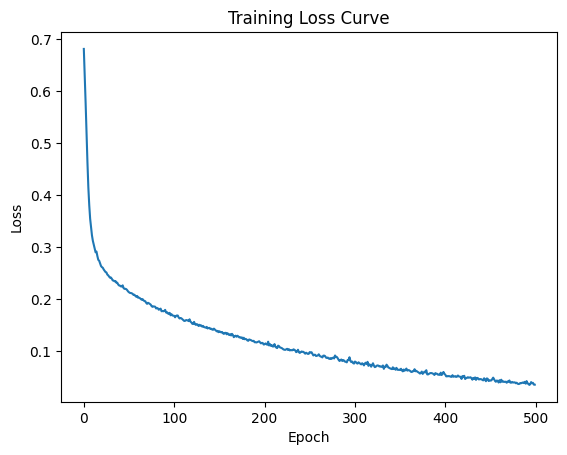

Accuracy: 0.9544
Precision: 0.4146
Recall: 0.8378
F1-Score: 0.5547
Confusion Matrix:
[[9260  401]
 [  55  284]]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# Loading Dataset
df = pd.read_csv('data/predictive_maintenance.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Separate features and target
X = df.drop(columns=['UDI', 'Product ID', 'Type', 'Target', 'Failure Type'])
y = df['Target']

# Combine features and target for balanced sampling 
df_balanced = pd.concat([X, y], axis=1)

# Separate the minority (failures) and majority (non-failures) classes
failures = df_balanced[df_balanced['Target'] == 1]
non_failures = df_balanced[df_balanced['Target'] == 0]

# Downsample the majority class (non-failures)
non_failures_downsampled = resample(non_failures, replace=False, n_samples=len(failures), random_state=42)

# Combine the downsampled non-failures and failures into a balanced dataset
df_balanced = pd.concat([failures, non_failures_downsampled])

X_balanced = df_balanced.drop(columns=['Target'])
y_balanced = df_balanced['Target']

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)
X_test = scaler.transform(X)  # Normalize the full test set

# Train-test split (use the balanced dataset for training)
X_train, _, y_train, _ = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=0)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

# Define DataLoaders
batch_size = 16
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.0005

model = FeedForwardNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
num_epochs = 500
loss_values = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        preds = model(batch_X)
        loss = loss_fn(preds, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Keep track of loss
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}', end='\r')

# Plot loss curve
plt.plot(loss_values)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation
threshold = 0.95
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        preds = model(batch_X).squeeze()
        predicted_labels = (preds > threshold).float()
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)  # Calculate accuracy
precision = precision_score(true_labels, predictions, zero_division=1)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

torch.save(model.state_dict(), 'feedforward_nn_model.pth')



## Autoencoder

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      9973 non-null   float64
 1   Process temperature [K]  9973 non-null   float64
 2   Rotational speed [rpm]   9973 non-null   float64
 3   Torque [Nm]              9973 non-null   float64
 4   Tool wear [min]          9973 non-null   float64
 5   Target                   9973 non-null   int64  
 6   Type_H                   9973 non-null   bool   
 7   Type_L                   9973 non-null   bool   
 8   Type_M                   9973 non-null   bool   
dtypes: bool(3), float64(5), int64(1)
memory usage: 496.8 KB


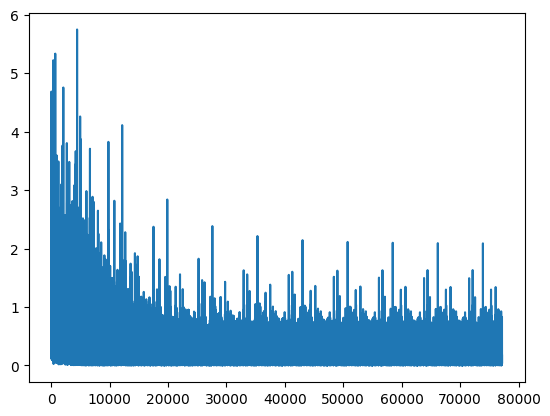

Threshold with maximum accuracy: 0.528023
Accuracy: 0.900251
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1926
           1       0.17      0.51      0.26        69

    accuracy                           0.90      1995
   macro avg       0.58      0.71      0.60      1995
weighted avg       0.95      0.90      0.92      1995



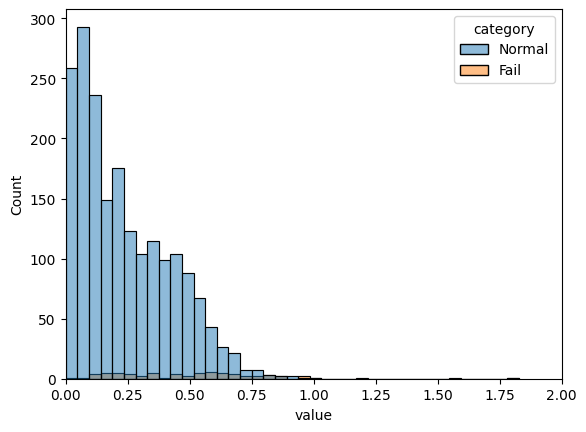

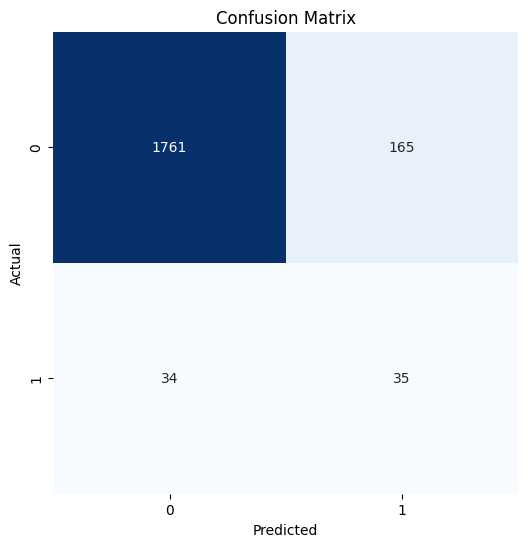

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Load Data
df = pd.read_csv('data/Cleaned_Predictive_Data.csv')

df.info()

df

# Feature Selection
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = df['Target']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_normal = X_train[~y_train]
X_test_normal = X_test[~y_test]

X_train_fail = X_train[y_train]
X_test_fail = X_test[y_test]

X_normal_tensor = torch.tensor(X_train_normal.values).to(torch.float32)

X_test_normal_tensor = torch.tensor(X_test_normal.values).to(torch.float32)
X_test_fail_tensor = torch.tensor(X_test_fail.values).to(torch.float32)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(5, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 5)
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
learning_rate = 1e-3
model = Autoencoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 10
batch_size = 1

# Model training
loss_values = []
model.train

for epoch in range(epochs):
    for i in range(0, len(X_normal_tensor), batch_size):
        # Pass only normal
        reconst = model(X_normal_tensor[i:i+batch_size])
        loss = loss_fn(reconst, X_normal_tensor[i:i+batch_size])

        # Back propagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Keep track of loss
        loss_values.append(loss.item())

        print('Epoch {0} Step {1}: Loss - {2}'.format(epoch+1, i+1, loss.item()), end='\r')

plt.plot(loss_values)
plt.show()

# Model evaluation
model.eval()

normal_loss = []
fail_loss = []

losses = []

for i in range(len(X_test_normal_tensor)):
    with torch.no_grad():
        reconst = model(X_test_normal_tensor[i])
        loss = loss_fn(reconst, X_test_normal_tensor[i])

        normal_loss.append(loss.item())
        losses.append({
            'y_true': 0,
            'error': loss.item()
        })
for i in range(len(X_test_fail_tensor)):
    with torch.no_grad():
        reconst = model(X_test_fail_tensor[i])
        loss = loss_fn(reconst, X_test_fail_tensor[i])

        fail_loss.append(loss.item())
        losses.append({
            'y_true': 1,
            'error': loss.item()
        })

df_normal = pd.DataFrame(normal_loss, columns=['value'])
df_fail = pd.DataFrame(fail_loss, columns=['value'])

df_normal['category'] = 'Normal'
df_fail['category'] = 'Fail'

df_test = pd.concat([df_normal, df_fail])

sns.histplot(data=df_test, x='value', hue='category')
plt.xlim([0, 2])

df_recon = pd.DataFrame(losses)

# Threshold Tuning
def threshold_tuning(df, iterations):
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1-score': []
    }

    for i in range(iterations):
        threshold = df['error'].quantile(i/iterations)
        preds = df['error'] > threshold
        cr = classification_report(df['y_true'], preds, output_dict=True)

        thresh_df['threshold'].append(threshold)
        thresh_df['accuracy'].append(cr['accuracy'])
        thresh_df['precision'].append(cr['macro avg']['precision'])
        thresh_df['recall'].append(cr['macro avg']['recall'])
        thresh_df['f1-score'].append(cr['macro avg']['f1-score'])
    
    return pd.DataFrame(thresh_df)

thresh_df = threshold_tuning(df_recon, 10)
optimal_threshold = thresh_df[thresh_df['accuracy'] == thresh_df['accuracy'].max()]
threshold = optimal_threshold['threshold'].values[0]
print(f'Threshold with maximum accuracy: {threshold:.6f}\nAccuracy: {optimal_threshold["accuracy"].values[0]:.6f}')

# Results
df_recon['y_pred'] = df_recon['error'] > threshold
print(classification_report(df_recon['y_true'], df_recon['y_pred']))
cm = confusion_matrix(df_recon['y_true'], df_recon['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save
torch.save(model.state_dict(), 'output/autoencoder.pth')


## Decision Tree

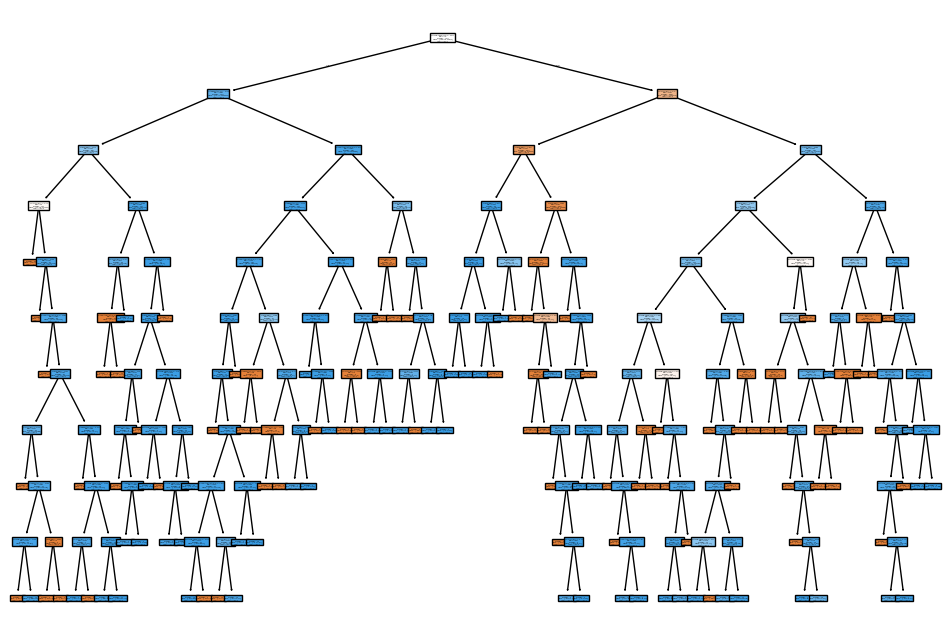

Decision Tree Metrics:
Accuracy:  0.9804511278195489
Precision:  0.7076923076923077
Recall:  0.696969696969697
F1 Score:  0.702290076335878


['decision_tree_model.joblib']

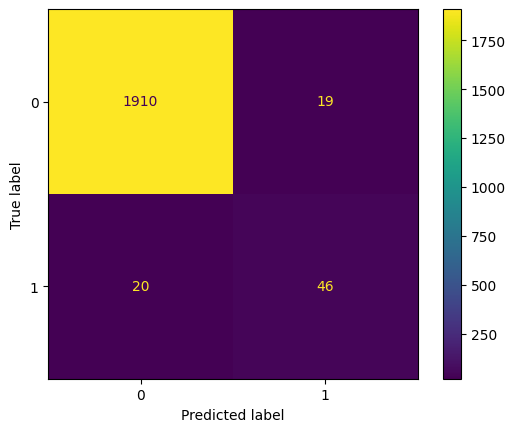

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load Data
df = pd.read_csv('data/Cleaned_Predictive_Data.csv')

A = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
b = df['Target']

# Train-Test Split
A_train, A_test, b_train, b_test = train_test_split(
    A, b, test_size=0.2, random_state=42, stratify=b
)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(b),
    y=b
)
class_weights_dict = dict(zip(np.unique(b), class_weights))

# Decision Tree with Hyperparameter Tuning
param_grid = {
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'class_weight': [class_weights_dict],
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search.fit(A_train, b_train)
model = grid_search.best_estimator_

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=A.columns, class_names=['Class 0', 'Class 1'], filled=True)
plt.show()

b_proba = model.predict_proba(A_test)[:, 1]
threshold = 0.95
b_pred = (b_proba >= threshold).astype(int)

cf = confusion_matrix(b_test, b_pred)
disp = ConfusionMatrixDisplay(cf)
disp.plot()

tn, fp, fn, tp = cf.ravel()
accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Decision Tree Metrics:')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)

joblib.dump(model, 'decision_tree_model.joblib')

## XGBoost Model


XGBoost Metrics:
Accuracy:  0.9854636591478697
Precision:  0.7936507936507936
Recall:  0.7575757575757576
F1 Score:  0.7751937984496123


['xgb_model.joblib']

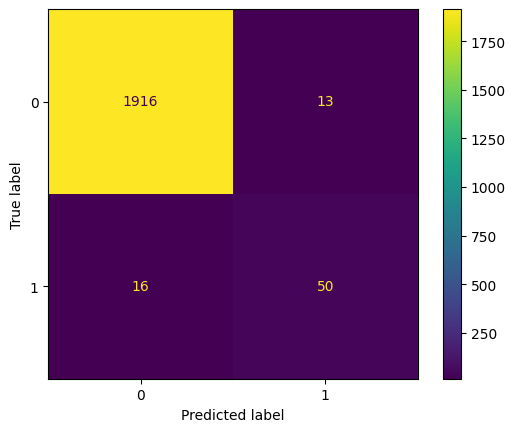

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import numpy as np
import joblib

# Load Data
df = pd.read_csv('data/Cleaned_Predictive_Data.csv')
df.columns = df.columns.str.replace('[\[\]<]', '', regex=True).str.replace(' ', '_')

# Feature Selection
A = df[['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']]
b = df['Target']

# Train-Test Split
A_train, A_test, b_train, b_test = train_test_split(
    A, b, test_size=0.2, random_state=42, stratify=b
)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(b),
    y=b
)
class_weights_dict = dict(zip(np.unique(b), class_weights))

# XGBoost Model
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=class_weights[1] / class_weights[0],
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100
)

xgb_model.fit(A_train, b_train)

b_proba_xgb = xgb_model.predict_proba(A_test)[:, 1]
threshold_xgb = 0.9
b_pred_xgb = (b_proba_xgb >= threshold_xgb).astype(int)

cf_xgb = confusion_matrix(b_test, b_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(cf_xgb)
disp_xgb.plot()

tn_xgb, fp_xgb, fn_xgb, tp_xgb = cf_xgb.ravel()
accuracy_xgb = (tn_xgb + tp_xgb) / (tn_xgb + fp_xgb + fn_xgb + tp_xgb)
precision_xgb = tp_xgb / (tp_xgb + fp_xgb)
recall_xgb = tp_xgb / (tp_xgb + fn_xgb)
f1_score_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)

print('\nXGBoost Metrics:')
print('Accuracy: ', accuracy_xgb)
print('Precision: ', precision_xgb)
print('Recall: ', recall_xgb)
print('F1 Score: ', f1_score_xgb)

joblib.dump(xgb_model, 'xgb_model.joblib')
